# 94-775/95-865 Dimensionality Reduction, Clustering, Cluster Interpretation, and Automatically Choosing k

Author: George H. Chen (georgechen [at symbol] cmu.edu)

This demo uses the UCI drug consumption dataset:
https://archive.ics.uci.edu/ml/datasets/Drug+consumption+%28quantified%29#

We begin with some boilerplate code.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn')
%config InlineBackend.figure_format = 'retina'  # if you use a Mac with Retina display

## Loading and preprocessing data

Next, we load in the UCI drug consumption data (which we assume resides in the same directory as this notebook). Each data point is represented as a 12-dimensional feature vector. Even though some of these features are not numerical (e.g., gender), they have been turned into numerical values (see the documentation on the UCI drug consumption data for what the numerical values mean for features that were originally not numerical).

In [2]:
import csv
import numpy as np
np.set_printoptions(suppress=True)  # somewhat prettier printing

drug_data = []
with open('./drug_consumption.data', 'r') as csvfile:
    csv_reader = csv.reader(csvfile, delimiter=',')
    for row in csv_reader:
        # row[0] is an ID, which we ignore
        # row[1], row[2], ..., row[12] correspond to the 12 feature vectors we care about
        drug_data.append([float(x) for x in row[1:13]])
drug_data = np.array(drug_data)  # convert the data to be a numpy array

In [3]:
drug_data.shape

(1885, 12)

We next standardize the data. Note that each row of `drug_data` corresponds to a different person, and each column corresponds to a different feature. Here, the standardization done subtracts off the mean of each column and divides by the standard deviation of the column (so that each column has mean 0 and unit variance):

In [4]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
drug_data_normalized = scaler.fit_transform(drug_data)

## Dimensionality reduction with PCA

Next we use PCA to bring the dimensionality of the data from 12 down to 2.

In [5]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
drug_data_normalized_pca2d = pca.fit_transform(drug_data_normalized)

We can plot the 2D PCA representation (in the second line here, I ask for the two axes to use the same scaling, i.e., you'll notice that the grid lines form squares):

(-4.785092557291803, 5.24773228411356, -4.96888019821361, 5.094724057982495)

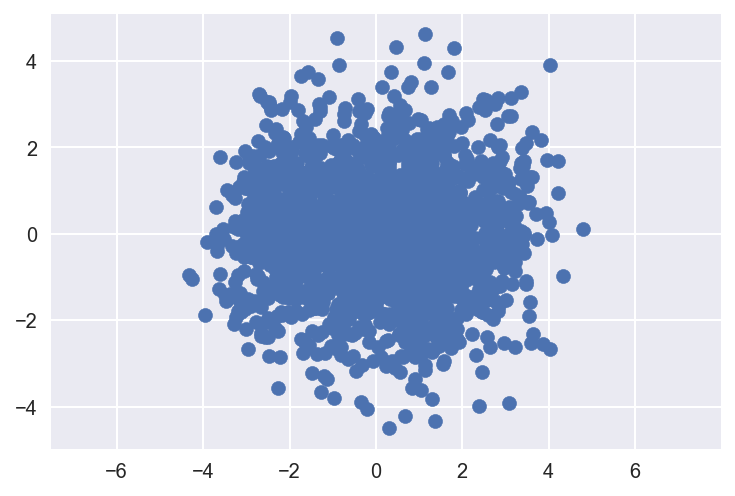

In [6]:
plt.scatter(drug_data_normalized_pca2d[:, 0], drug_data_normalized_pca2d[:, 1])
plt.axis('equal')

In [7]:
print(pca.components_[0])

[-0.30814595 -0.24522535 -0.21510942 -0.36956402  0.10774476  0.21829237
 -0.05229747  0.27205377 -0.24354739 -0.33911344  0.40360201  0.43456227]


In [8]:
np.inner(pca.components_[1], drug_data_normalized[0])

1.2516601192871781

In [9]:
drug_data_normalized_pca2d[0]

array([-0.8930275 ,  1.25166012])

In [10]:
print(pca.components_[1])

[ 0.09329346  0.01478971 -0.17640044  0.03786158 -0.05526341  0.44066646
 -0.59335285 -0.38671826 -0.22543    -0.33520093 -0.13581118 -0.2793642 ]


In [11]:
pca.explained_variance_ratio_

array([0.24249161, 0.15598527])

## Dimensionality reduction with t-SNE

Next, I apply t-SNE. Note that the code is nearly identical to using PCA: we import the nonlinear dimensionality reduction method we want to use (`TSNE`), create an instance of it (which we name `tsne`), and for that particular instance, we do `fit_transform` on the data. **Warning:** t-SNE takes way longer to run than PCA.

In [12]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=0)  # note: in practice you should actually play with the perplexity, learning rate, and number of iterations
drug_data_normalized_tsne2d = tsne.fit_transform(drug_data_normalized)

Plotting is done just like before, except now we use our newly defined variable `drug_data_normalized_tsne2d`:

(-57.40638885270168, 48.66960296402979, -59.19674732413162, 65.38699390616287)

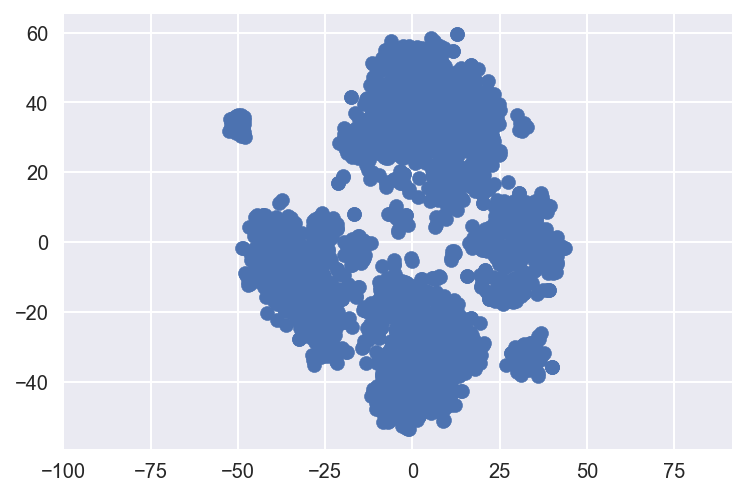

In [13]:
plt.scatter(drug_data_normalized_tsne2d[:, 0], drug_data_normalized_tsne2d[:, 1])
plt.axis('equal')

Unlike in PCA, in general for nonlinear dimensionality reduction methods, the axes aren't as easy to interpret. Each axis here is no longer just a simple weighted combination of the original features. In terms of interpretation, the main thing here is that points close to each other are more similar, and points far away from each other are more dissimilar.


However, with t-SNE, we are able to get some distinct blobs that appear. Could these blobs be semantically interesting? Possibly! (And possibly not!) Let's try to figure out what these clusters are...

## Clustering using k-means

From the visualization above, it looks like there are maybe something like 6 clusters (small ones in the top left and bottom right, and then four bigger clusters in the middle). Let's try k-means with k=6...

(-57.40638885270168, 48.66960296402979, -59.19674732413162, 65.38699390616287)

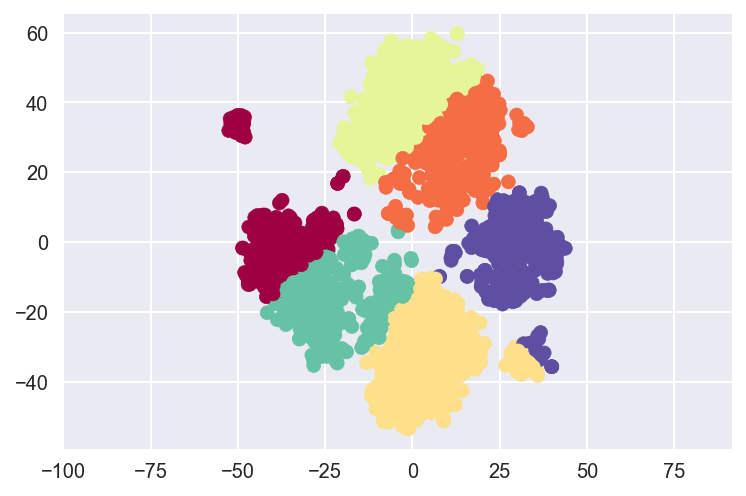

In [14]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=6, n_init=1000, random_state=0)
kmeans.fit(drug_data_normalized_tsne2d)

kmeans_cluster_assignments = kmeans.predict(drug_data_normalized_tsne2d)

plt.scatter(drug_data_normalized_tsne2d[:, 0], drug_data_normalized_tsne2d[:, 1],
            c=kmeans_cluster_assignments, cmap='Spectral')
# - `c` specifies how the different points should be colored (here, I set it to the
#   cluster assignments so different clusters get different colors)
plt.axis('equal')

These clusters don't look very good (they probably don't correspond to what you thought should have been the answer). In particular, the middle four blobs get cut up and assigned to different clusters.

## Clustering using a Gaussian mixture model (GMM)

Let's instead cluster using a GMM. A GMM is going to be in some sense more general than what a k-means "model" can capture. The fitting code is almost the same as in k-means. Since fitting a GMM takes more time than running k-means, we use fewer random initializations (200 here instead of 1000 earlier; you could of course use more random initializations if you have the computational resources to do so).

In [15]:
from sklearn.mixture import GaussianMixture

gmm = GaussianMixture(n_components=6, n_init=1000, random_state=0)
gmm.fit(drug_data_normalized_tsne2d)

print(np.sort(gmm.weights_)[::-1])  # print out probability of fitted clusters in decreasing weight

[0.35496044 0.23369254 0.22765205 0.12685717 0.03934004 0.01749777]


In [16]:
gmm.means_

array([[-29.87697782,  -9.76658205],
       [ 30.10271653,  -1.98717884],
       [  4.35871537,  33.62918151],
       [  2.02132799, -31.05967561],
       [-49.839568  ,  33.62406534],
       [ 28.15392859, -32.44633095]])

Finally, we plot the GMM clusters:

(-57.40638885270168, 48.66960296402979, -59.19674732413162, 65.38699390616287)

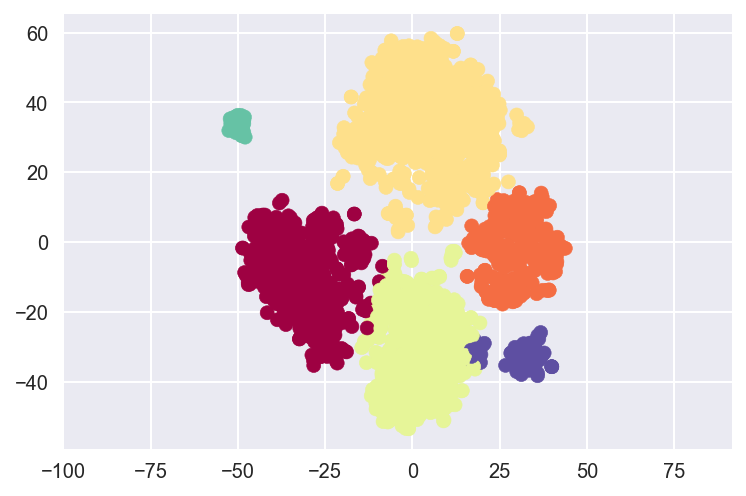

In [17]:
gmm_cluster_assignments = gmm.predict(drug_data_normalized_tsne2d)
plt.scatter(drug_data_normalized_tsne2d[:, 0], drug_data_normalized_tsne2d[:, 1],
            c=gmm_cluster_assignments, cmap='Spectral')
plt.axis('equal')

## A sketch of how to do interpretation

The above clustering looks better than the k-means clustering. Note, however, that we have not actually carefully checked yet whether these clusters found are actually semantically meaningful in any way. To do so, we should look at what sorts of feature vectors land in each of these clusters, and interpret these clusters in terms of the original features (recall that these include psychological measures, level of education, age, gender, country of residence, and ethnicity--although not in this particular order). For example, if we wanted to carefully look at what the original feature vectors are for all the individuals in cluster 2, we would use the following code snippet:

In [18]:
# drug_data_normalized[gmm_cluster_assignments == 2]

In [19]:
drug_data_normalized[gmm_cluster_assignments == 2].mean(axis=0)

array([ 0.31076246,  0.98259342,  0.30867668,  0.75225662,  0.0496163 ,
       -0.04455415,  0.13699723, -0.38790743,  0.29780028,  0.36491378,
       -0.34105146, -0.44138178])

For example, we can plot out all the cluster centers:

Text(0, 0.5, 'Feature value')

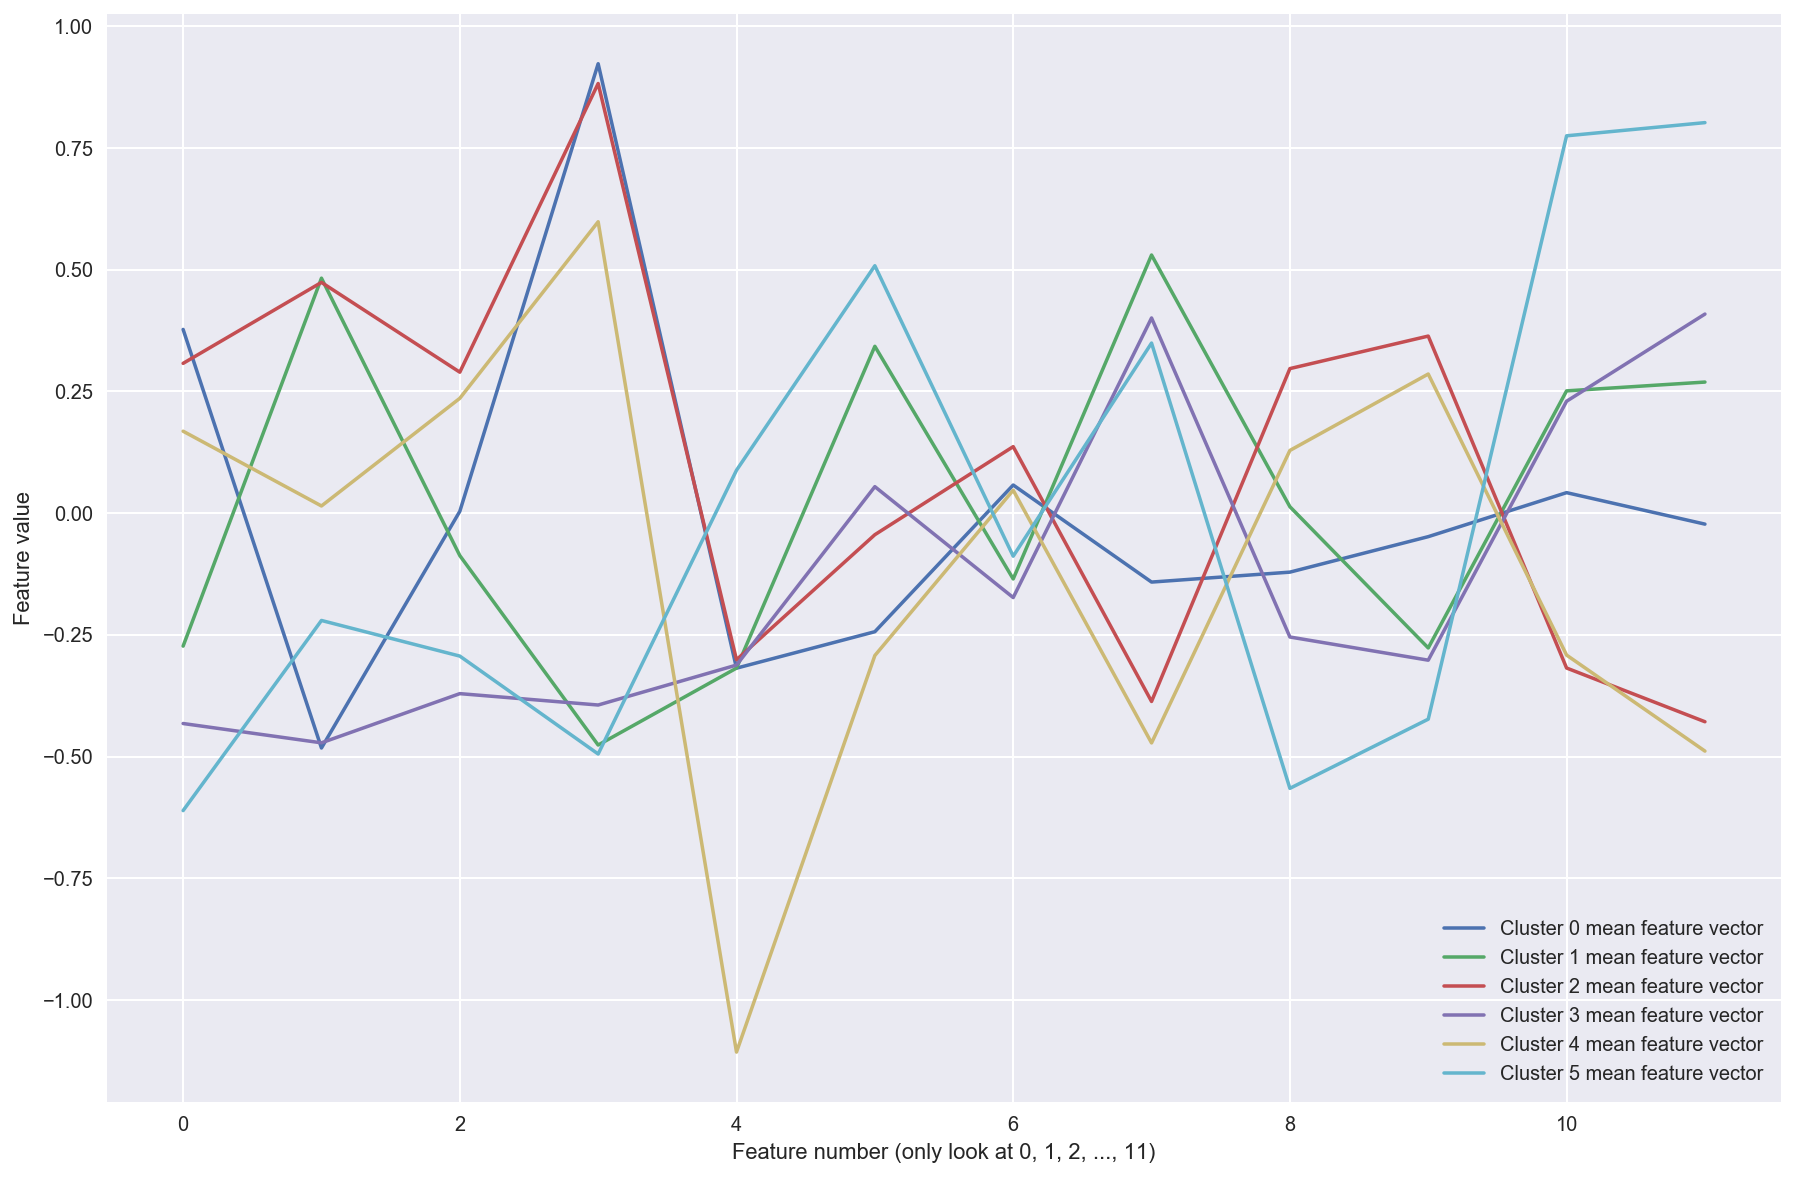

In [20]:
plt.figure(figsize=(15, 10))
for cluster in range(gmm_cluster_assignments.max() + 1):
    plt.plot(drug_data[gmm_cluster_assignments == cluster].mean(axis=0),
             label=('Cluster ' + str(cluster) +' mean feature vector'))
plt.legend(loc='lower right')
plt.xlabel('Feature number (only look at 0, 1, 2, ..., 11)')
plt.ylabel('Feature value')

The plot above shows in which features the cluster centers differ in.

Note that the above plot is unsatisfying in several ways:

* A line doesn't actually make sense (e.g., what does it mean to be at feature 0.5?--this doesn't make any sense since the features are only at 0, 1, 2, ..., 11). However, if you don't draw the lines and only draw dots, the plot becomes really hard to read (you can try it by adding a parameter 'o' before the 'label' parameter to the `plt.plot` line).
* What do the feature values mean? Here, we have to go back to the [documentation](https://archive.ics.uci.edu/ml/datasets/Drug+consumption+%28quantified%29)! Feature 0 corresponds to age, feature 1 to gender, feature 3 to education, and so forth -- all features have been turned into numerical values.

Let's focus on age (feature 0) for a specific cluster, say cluster 2. So, we pull the 0th column using numpy fancy indexing:

In [21]:
drug_data[gmm_cluster_assignments == 2][:, 0]

array([ 0.49788, -0.95197,  0.49788,  2.59171,  0.49788, -0.07854,
        1.82213,  1.82213,  1.82213,  0.49788,  1.82213,  0.49788,
        0.49788,  2.59171,  2.59171,  0.49788, -0.07854, -0.07854,
        1.09449, -0.07854,  1.82213,  1.82213,  0.49788, -0.07854,
       -0.07854,  1.09449,  1.09449,  2.59171,  1.09449,  2.59171,
        1.82213,  1.82213, -0.07854,  0.49788,  0.49788,  0.49788,
        2.59171,  0.49788,  1.09449, -0.07854,  1.09449,  1.09449,
       -0.07854, -0.07854,  0.49788, -0.07854,  1.09449, -0.07854,
        1.09449, -0.07854, -0.07854,  0.49788, -0.07854,  0.49788,
       -0.07854,  1.09449,  1.09449,  1.09449,  1.09449,  0.49788,
       -0.07854,  0.49788,  1.09449,  1.09449, -0.07854,  0.49788,
        1.09449,  0.49788,  1.09449,  0.49788,  0.49788, -0.07854,
       -0.95197,  0.49788,  0.49788, -0.07854, -0.07854, -0.07854,
       -0.95197,  1.09449,  0.49788,  0.49788,  1.82213,  0.49788,
        0.49788,  1.09449,  0.49788,  1.09449,  0.49788, -0.95

The above values clearly aren't real ages (we have negative values!). Instead, if you look at the [documentation](https://archive.ics.uci.edu/ml/datasets/Drug+consumption+%28quantified%29), you'll see that they've actually discretized ages into 6 possible real values:

* -0.95197 corresponds to ages 18-24
* -0.07854 corresponds to ages 25-34
* 0.49788 corresponds to ages 35-44
* 1.09449 corresponds to ages 45-54
* 1.82213 corresponds to ages 55-64
* 2.59171 corresponds to ages 65+

So to plot out the distribution of ages, we would plot a histogram of the above values! At this point, you should hopefully be skilled at computing histograms (which we did at the start of class with basic text analysis).

In [ ]:
from collections import Counter
def plot_histogram(feature_values, labels):
    
    histogram = Counter()
    for val in feature_values:
        histogram[val] += 1
    sorted_key_val_pairs = sorted(list(histogram.items()))
    sorted_keys, sorted_vals = zip(*sorted_key_val_pairs)
    plt.bar(range(len(sorted_keys)), sorted_vals)
    plt.xticks(range(len(sorted_keys)), [labels[key] for key in sorted_keys])

In [ ]:
plot_histogram(drug_data[gmm_cluster_assignments == 2][:, 0],
               {-0.95197: '18-24',
                -0.07854: '25-34',
                0.49788: '35-44',
                1.09449: '45-54',
                1.82213: '55-64',
                2.59171: '65+'})

At this point you can examine the age distribution for the different clusters. This same idea can be used to examine distributions for other features and clusters.

## Automatically choosing k (using a score function for each k)

The simplest way is to try a bunch of different values of k, and for each value of k, fit a model and compute a score for the model (so the score depends on k). Then we pick whichever k corresponds to the best score.

There are many score functions you can use. For example, scikit-learn provides [these](http://scikit-learn.org/stable/modules/classes.html#clustering-metrics), one of which is the CH index we discussed in the lecture slides (documentation for computing the CH index in scikit-learn is [here](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.calinski_harabaz_score.html)).

In [ ]:
from sklearn.metrics import calinski_harabaz_score

best_score = -np.inf
best_k = None
best_model = None
best_cluster_assignments = None

for k in range(2, 11):
    candidate_gmm = GaussianMixture(n_components=k, n_init=100, random_state=0)
    candidate_gmm.fit(drug_data_normalized_tsne2d)
    cluster_assignments = candidate_gmm.predict(drug_data_normalized_tsne2d)
    score = calinski_harabaz_score(drug_data_normalized_tsne2d, cluster_assignments)
    
    print('k =', k, 'has CH index', score)
    
    if score > best_score:
        best_score = score
        best_k = k
        best_model = candidate_gmm
        best_cluster_assignments = cluster_assignments
    
print('Best k within 2, 3, ..., 10 according to CH index:', best_k)

gmm_cluster_assignments = gmm.predict(drug_data_normalized_tsne2d)
plt.scatter(drug_data_normalized_tsne2d[:, 0], drug_data_normalized_tsne2d[:, 1],
            c=best_cluster_assignments, cmap='Spectral')
plt.axis('equal')